In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from tqdm import trange
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import mode
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics import silhouette_score, davies_bouldin_score

In [2]:
df = pd.read_csv("customer_dataframe.csv", sep="\t", index_col=0)
df.head()

,TProd,DProd,MaxPO,MinPO,MeanProdOrder,TSale,MinPSale,MaxPSale,MeanSaleOrder,TRProd,MeanPSale,TOrder,SETSaleQta,SESaleQtaOrder
CustomerID,,,,,,,,,,,,,,
17850,1702,21,141,12,48.629,5317.89,6.36,107.25,151.940,31,3.960,34,4.137,3.186
13047,1355,105,309,3,84.688,3089.10,6.64,68.00,193.069,35,3.926,9,5.421,3.875
12583,4978,114,714,100,292.824,6629.34,6.80,132.80,389.961,50,2.140,15,5.804,4.087
13748,439,24,208,8,87.800,948.25,9.36,204.00,189.650,0,3.996,5,4.080,2.322
15100,58,1,32,16,9.667,635.10,175.20,350.40,105.850,22,10.950,3,2.252,2.252


# Index selection for clustering

Only a small part of all the indexes in the dataset will be used during the process of clustering. The chosen attributes are the ones that better characterize che usual behaviour of a customer.

In [3]:
df_aux = df[['TProd', 'MeanProdOrder', 'MeanSaleOrder', 'MeanPSale']]
df_aux.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4333 entries, 17850 to 12713
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   TProd          4333 non-null   int64  
 1   MeanProdOrder  4333 non-null   float64
 2   MeanSaleOrder  4333 non-null   float64
 3   MeanPSale      4333 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 169.3 KB


In [4]:
df_aux.describe()

,TProd,MeanProdOrder,MeanSaleOrder,MeanPSale
count,4333.000000,4333.000000,4333.000000,4333.000000
mean,1129.535657,201.104614,327.882896,3.492819
std,4692.695935,274.590134,395.336014,8.997404
min,0.000000,0.000000,0.000000,0.122000
25%,157.000000,80.500000,155.050000,2.160000
50%,370.000000,140.167000,241.900000,2.834000
75%,971.000000,237.750000,371.560000,3.712000
max,196556.000000,7824.000000,9904.875000,434.650000


In [5]:
scaler = MinMaxScaler()
X = scaler.fit_transform(df_aux.values)

In [6]:
X[:2]

array([[0.00865911, 0.00621536, 0.01533992, 0.00883257],
       [0.00689371, 0.01082413, 0.01949232, 0.00875433]])

### Defining functions that will be usefull for re-elaborate data and analyze results

In [7]:
# from the hierarchical clustering defined by the given linkage matrix and threshold return the cluster topology
def count_cluster_elements(data, threshold, criterion='distance'):
    count = {}
    clusters = fcluster(data, threshold, criterion)
    for c in clusters:
        count[c] = count[c]+1 if c in count else 1
    return count, clusters

In [8]:
# from flat clusters returns dictionary of dataframes representing the cluster
def get_dataframe(complete_df, flat_cluster):
    distinct_clusters = list(set(flat_cluster))
    sorted(distinct_clusters)
    cluster_index = {c:[] for c in distinct_clusters} 
    for i in range(len(flat_cluster)):
        cluster_index[flat_cluster[i]].append(i)
    clusters_df = {}
    indexes = df.index
    for c in distinct_clusters:
        elem = cluster_index[c]
        clusters_df[c] = df[df.index.isin([indexes[i] for i in elem])]
    return clusters_df

In [9]:
def plot_cluster_values(cdf, df_aux):
    attr = df_aux.columns
    clusters = [i for i in cdf]
    colors = ["red", "blue", "green", "yellow", "orange", "brown"]
    fig, axs = plt.subplots(len(attr),3,figsize=(15,15))
    for attr_index in range(len(attr)):
        mean_values = []
        max_values = []
        min_values = []
        for _, cluster_df in cdf.items():
            mean_values.append(cluster_df.describe()[attr[attr_index]][1])
            max_values.append(cluster_df.describe()[attr[attr_index]][7])
            min_values.append(cluster_df.describe()[attr[attr_index]][3])
        axs[attr_index][0].bar(clusters, mean_values, color=colors[:len(clusters)])
        axs[attr_index][0].set_title(f"{attr[attr_index]} - Mean")
        axs[attr_index][1].bar(clusters, max_values, color=colors[:len(clusters)])
        axs[attr_index][1].set_title(f"{attr[attr_index]} - Max")
        axs[attr_index][2].bar(clusters, min_values, color=colors[:len(clusters)])
        axs[attr_index][2].set_title(f"{attr[attr_index]} - Min")

# Complete - Euclidean

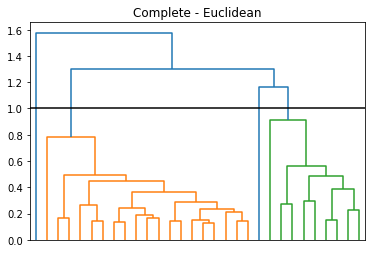

In [10]:
data_dist = pdist(X, metric='euclidean')
data_link = linkage(data_dist, method='complete', metric='euclidean')
threshold_value = 1.0
res = dendrogram(data_link, color_threshold=threshold_value, truncate_mode='lastp')
plt.tick_params(labelbottom=False)
plt.title("Complete - Euclidean")
plt.axhline(y=threshold_value, color="black")

In [11]:
conta, clusters = count_cluster_elements(data_link, threshold_value)
print("Clusters:", len(conta.keys()))
print(list(reversed(sorted(conta.values()))))

Clusters: 4
[4311, 20, 1, 1]


In [12]:
score = silhouette_score(X, clusters)
print(f"Silhouette score: {score}")

Silhouette score: 0.9229675968079302


[1:4311] [2:20] [3:1] [4:1] 

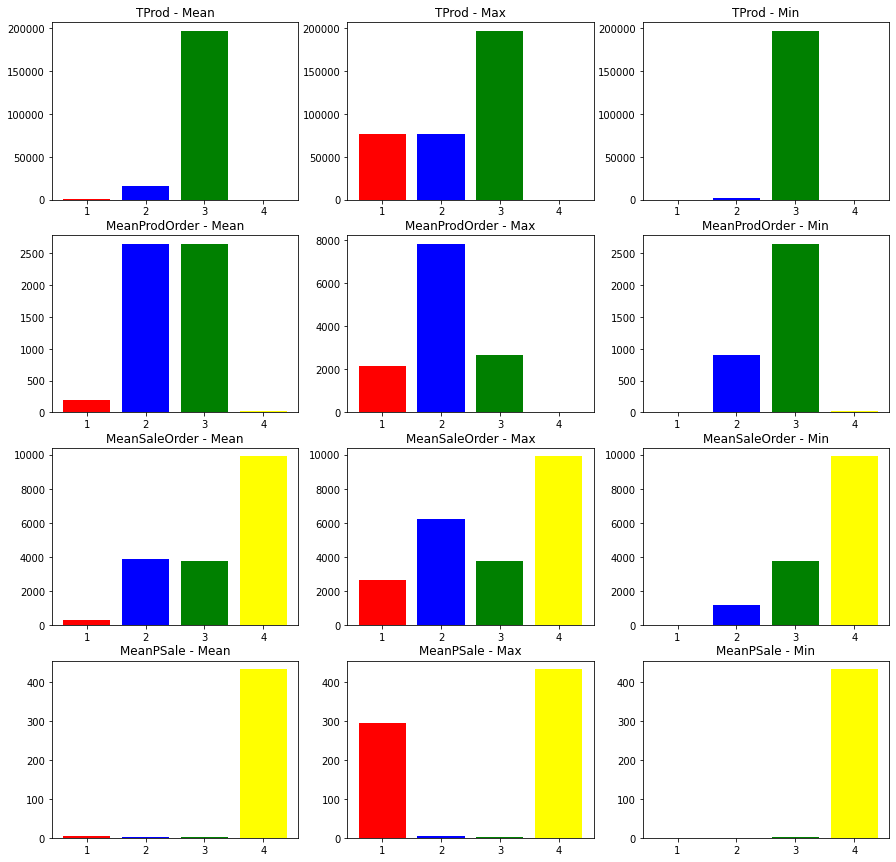

In [13]:
cdf = get_dataframe(df, clusters)
for cluster, cluster_df in cdf.items():
    print(f"[{cluster}:{len(cluster_df)}]", end=" ")
plot_cluster_values(cdf, df_aux)

# Single - Euclidean

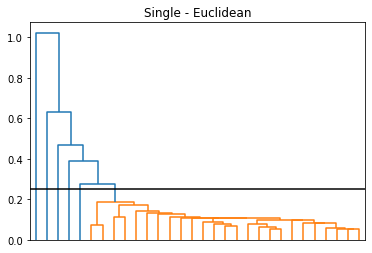

In [14]:
data_dist = pdist(X, metric='euclidean')
data_link = linkage(data_dist, method='single', metric='euclidean')
threshold_value = 0.25
res = dendrogram(data_link, color_threshold=threshold_value, truncate_mode='lastp')
plt.tick_params(labelbottom=False)
plt.title("Single - Euclidean")
plt.axhline(y=threshold_value, color="black")

In [15]:
conta, clusters = count_cluster_elements(data_link, threshold_value)
print("Clusters:", len(conta.keys()))
print(list(reversed(sorted(conta.values()))))

Clusters: 6
[4328, 1, 1, 1, 1, 1]


In [16]:
score = silhouette_score(X, clusters)
print(f"Silhouette score: {score}")

Silhouette score: 0.9350227049491753


[1:4328] [2:1] [3:1] [4:1] [5:1] [6:1] 

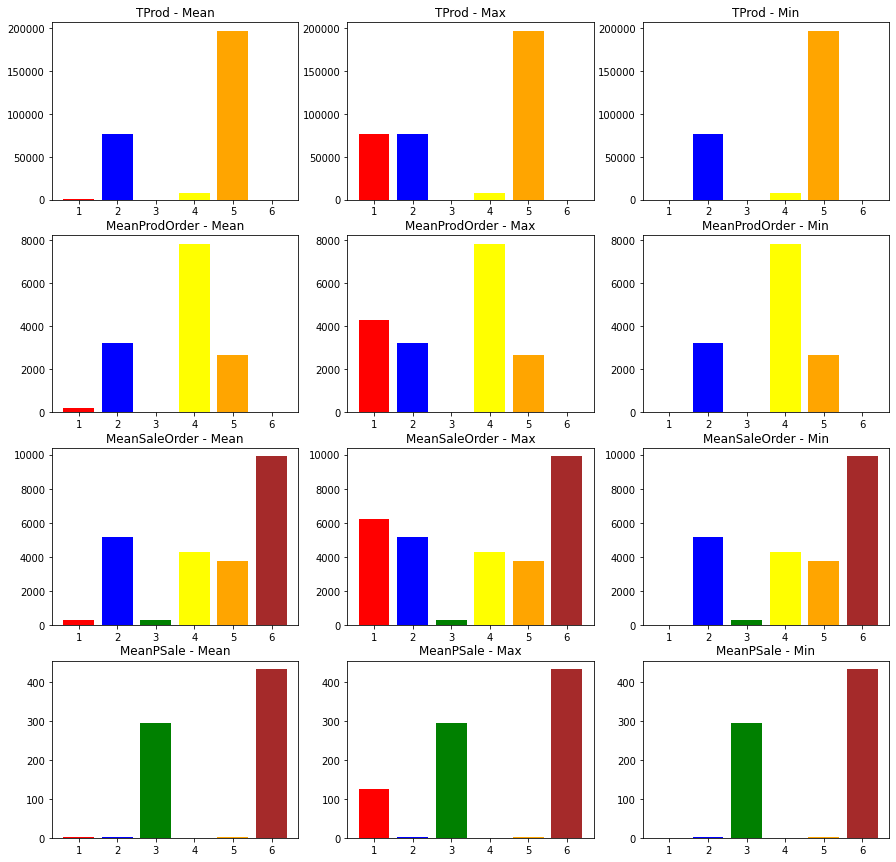

In [17]:
cdf = get_dataframe(df, clusters)
for cluster, cluster_df in cdf.items():
    print(f"[{cluster}:{len(cluster_df)}]", end=" ")
plot_cluster_values(cdf, df_aux)

# Avereage - Euclidean

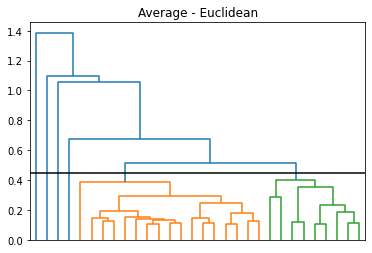

In [18]:
data_dist = pdist(X, metric='euclidean')
data_link = linkage(data_dist, method='average', metric='euclidean')
threshold_value = 0.45
res = dendrogram(data_link, color_threshold=threshold_value, truncate_mode='lastp')
plt.tick_params(labelbottom=False)
plt.title("Average - Euclidean")
plt.axhline(y=threshold_value, color="black")

In [19]:
conta, clusters = count_cluster_elements(data_link, threshold_value)
print("Clusters:", len(conta.keys()))
print(list(reversed(sorted(conta.values()))))

Clusters: 6
[4312, 17, 1, 1, 1, 1]


In [20]:
score = silhouette_score(X, clusters)
print(f"Silhouette score: {score}")

Silhouette score: 0.9206974421486209


[1:4312] [2:17] [3:1] [4:1] [5:1] [6:1] 

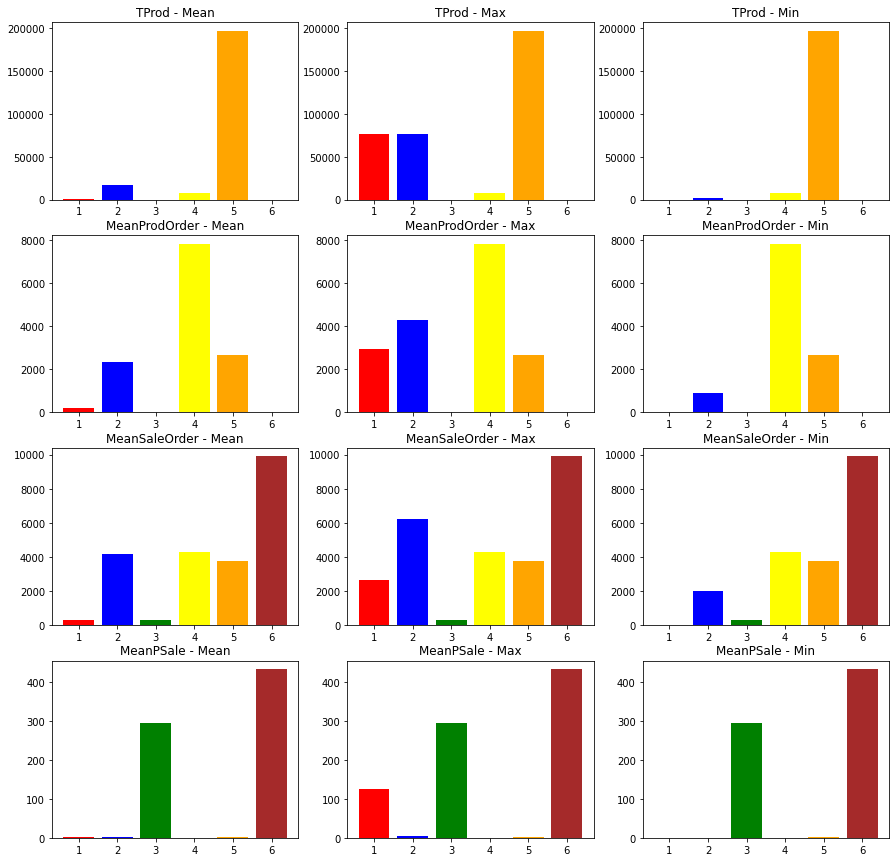

In [21]:
cdf = get_dataframe(df, clusters)
for cluster, cluster_df in cdf.items():
    print(f"[{cluster}:{len(cluster_df)}]", end=" ")
plot_cluster_values(cdf, df_aux)

# Ward - Euclidean

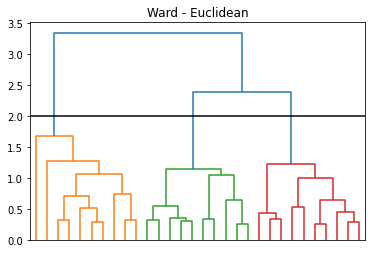

In [22]:
data_dist = pdist(X, metric='euclidean')
data_link = linkage(data_dist, method='ward', metric='euclidean')
threshold_value = 2.0
res = dendrogram(data_link, color_threshold=threshold_value, truncate_mode='lastp')
plt.tick_params(labelbottom=False)
plt.title("Ward - Euclidean")
plt.axhline(y=threshold_value, color="black")

In [23]:
conta, clusters = count_cluster_elements(data_link, threshold_value)
print("Clusters:", len(conta.keys()))
print(list(reversed(sorted(conta.values()))))

Clusters: 3
[3853, 458, 22]


In [24]:
score = silhouette_score(X, clusters)
print(f"Silhouette score: {score}")

Silhouette score: 0.6717133967267056


[1:22] [2:3853] [3:458] 

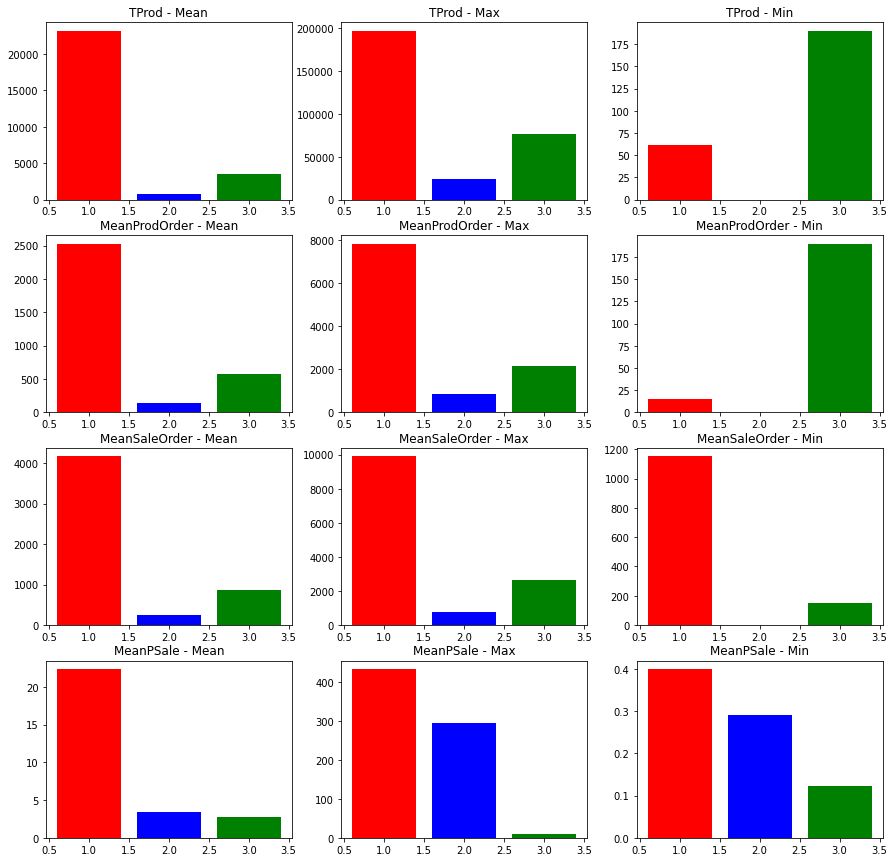

In [25]:
cdf = get_dataframe(df, clusters)
for cluster, cluster_df in cdf.items():
    print(f"[{cluster}:{len(cluster_df)}]", end=" ")
plot_cluster_values(cdf, df_aux)

# Ward - Euclidean

(Considering the outlier sample alone)

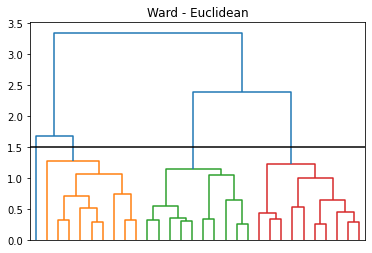

In [26]:
data_dist = pdist(X, metric='euclidean')
data_link = linkage(data_dist, method='ward', metric='euclidean')
threshold_value = 1.5
res = dendrogram(data_link, color_threshold=threshold_value, truncate_mode='lastp')
plt.tick_params(labelbottom=False)
plt.title("Ward - Euclidean")
plt.axhline(y=threshold_value, color="black")

In [27]:
conta, clusters = count_cluster_elements(data_link, threshold_value)
print("Clusters:", len(conta.keys()))
print(list(reversed(sorted(conta.values()))))

Clusters: 4
[3853, 458, 21, 1]


In [28]:
score = silhouette_score(X, clusters)
print(f"Silhouette score: {score}")

Silhouette score: 0.6721013455064441


[1:21] [2:1] [3:3853] [4:458] 

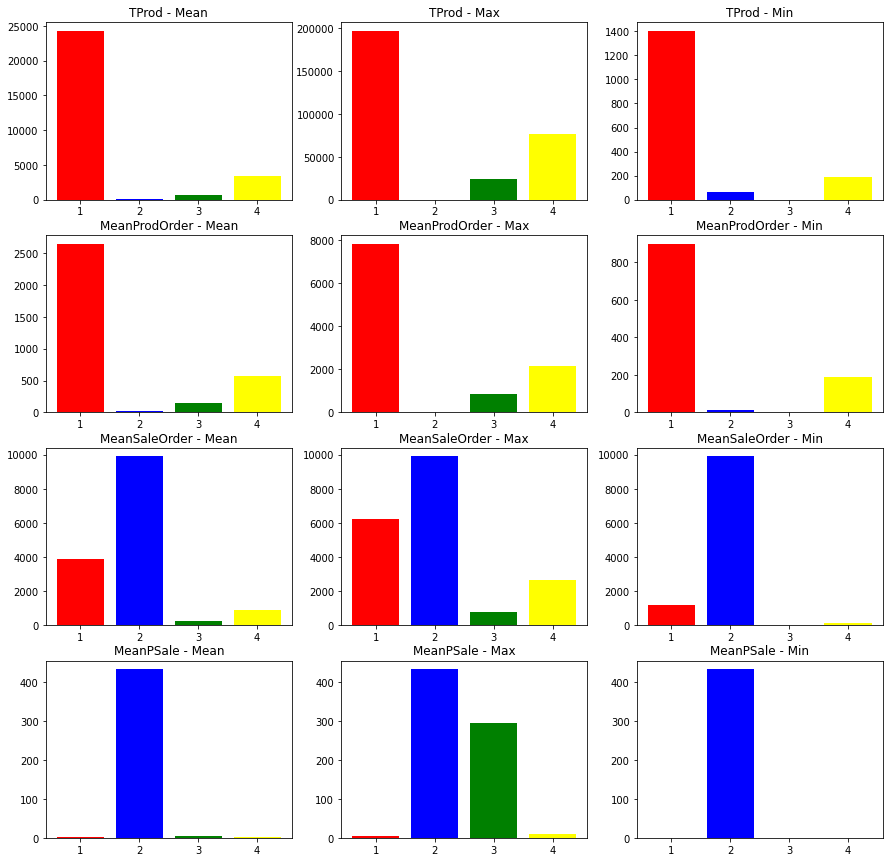

In [29]:
cdf = get_dataframe(df, clusters)
for cluster, cluster_df in cdf.items():
    print(f"[{cluster}:{len(cluster_df)}]", end=" ")
plot_cluster_values(cdf, df_aux)

# 

# Agglomerative Clustering

In [30]:
from sklearn.cluster import AgglomerativeClustering
connectivity=None

In [31]:
print("### Complete - Euclidean ###", end="\n\n")
for i in range(2, 5):
    complete = AgglomerativeClustering(n_clusters=i, linkage='complete', affinity='euclidean', connectivity=connectivity)
    complete.fit(X)
    hist, bins = np.histogram(complete.labels_, bins=range(0, len(set(complete.labels_)) + 1))
    
    print('Numero Cluster: ', i)
    print('Cluster', dict(zip(bins, hist)))
    print('Silhouette Score', silhouette_score(X, complete.labels_))
    print()

### Complete - Euclidean ###

Numero Cluster:  2
Cluster {0: 4332, 1: 1}
Silhouette Score 0.9687137721422231

Numero Cluster:  3
Cluster {0: 21, 1: 1, 2: 4311}
Silhouette Score 0.9265553774017546

Numero Cluster:  4
Cluster {0: 20, 1: 1, 2: 4311, 3: 1}
Silhouette Score 0.9229675968079302



In [32]:
print("### Single - Euclidean ###", end="\n\n")
for i in range(2, 5):
    complete = AgglomerativeClustering(n_clusters=i, linkage='single', affinity='euclidean', connectivity=connectivity)
    complete.fit(X)
    hist, bins = np.histogram(complete.labels_, bins=range(0, len(set(complete.labels_)) + 1))
    
    print('Numero Cluster: ', i)
    print('Cluster', dict(zip(bins, hist)))
    print('Silhouette Score', silhouette_score(X, complete.labels_))
    print()

### Single - Euclidean ###

Numero Cluster:  2
Cluster {0: 4332, 1: 1}
Silhouette Score 0.9687137721422231

Numero Cluster:  3
Cluster {0: 4331, 1: 1, 2: 1}
Silhouette Score 0.9604297674001191

Numero Cluster:  4
Cluster {0: 4330, 1: 1, 2: 1, 3: 1}
Silhouette Score 0.9579502745851489



In [33]:
print("### Average - Euclidean ###", end="\n\n")
for i in range(2, 5):
    complete = AgglomerativeClustering(n_clusters=i, linkage='average', affinity='euclidean', connectivity=connectivity)
    complete.fit(X)
    hist, bins = np.histogram(complete.labels_, bins=range(0, len(set(complete.labels_)) + 1))
    
    print('Numero Cluster: ', i)
    print('Cluster', dict(zip(bins, hist)))
    print('Silhouette Score', silhouette_score(X, complete.labels_))
    print()

### Average - Euclidean ###

Numero Cluster:  2
Cluster {0: 4332, 1: 1}
Silhouette Score 0.9687137721422231

Numero Cluster:  3
Cluster {0: 4331, 1: 1, 2: 1}
Silhouette Score 0.9604297674001191

Numero Cluster:  4
Cluster {0: 4330, 1: 1, 2: 1, 3: 1}
Silhouette Score 0.9579502745851489



In [34]:
print("### Ward - Euclidean ###", end="\n\n")
for i in range(2, 5):
    complete = AgglomerativeClustering(n_clusters=i, linkage='ward', affinity='euclidean', connectivity=connectivity)
    complete.fit(X)
    hist, bins = np.histogram(complete.labels_, bins=range(0, len(set(complete.labels_)) + 1))
    
    print('Numero Cluster: ', i)
    print('Cluster', dict(zip(bins, hist)))
    print('Silhouette Score', silhouette_score(X, complete.labels_))
    print('Davies-Bouldin Score', davies_bouldin_score(X, complete.labels_))
    print()

### Ward - Euclidean ###

Numero Cluster:  2
Cluster {0: 4311, 1: 22}
Silhouette Score 0.9308883038332841
Davies-Bouldin Score 0.6793311008821935

Numero Cluster:  3
Cluster {0: 22, 1: 458, 2: 3853}
Silhouette Score 0.6717133967267056
Davies-Bouldin Score 0.8419015649586915

Numero Cluster:  4
Cluster {0: 21, 1: 458, 2: 3853, 3: 1}
Silhouette Score 0.6721013455064441
Davies-Bouldin Score 0.6590717260952488

